# Aircraft Engine RUL Prediction

## Introduction

Prediction of Remaining Useful Life of any machine is very essential due to its ability to prevent failure occurrences and maintenance costs. At present, mathematical and statistical modeling are the prominent approaches used for it. These are based on equipment degradation physical models and machine learning methods, respectively. 

So, the objecive is to develop a system that identifies likelihood of failure of rotating equipment (for example motors, turbines) based on a stream of sensor data. The sensors monitor different parameters such as temperature, pressure and acceleration of different machine parts in order to keep a check on the performance of the rotary machine. At the server side, this data is used to train a machine learning model. This model predicts the remaining useful life (RUL) i.e., time to failure of the machine. These predictions are used to prevent failure of the machines by performing maintenance at appropriate time.

In this project I aim to model the task of estimating RUL of machines as a regression problem.

- Regression approach provides a prediction of the remaining useful life of the machine (in hours/cycles).

## Data

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1) unit number

2) time, in cycles

3) operational setting 1

4) operational setting 2

5) operational setting 3

6) sensor measurement 1

7) sensor measurement 2

...

26) sensor measurement 26

The training set includes operational data from 100 different engines. In each data set, the engine was run for a variable number of cycles until failure. The lengths of the run varied with a minimum run length of 128 cycles and the maximum length of 356 cylces.

The testing set includes operational data from 100 different engines. The engines in the test dataset and copletely different from engines in the training data set.

## Importing Required Libraries and Data

In [124]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler #to normalize data


#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop,adam
from keras.callbacks import History
from keras import callbacks

In [125]:
# Input files don't have column names
dependent_var = ['RUL']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

Importing train dataset and calculating remaining useful life

In [126]:
df_train = pd.read_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Projects\\Manufacturing\\Airplane Turbofan Engine RUL Prediction\\CMAPSSData\\train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
df_train['RUL'] = df_train['max'] - df_train['Cycle']
df_train.drop('max', axis=1, inplace=True)

df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Importing Test dataset

In [127]:
df_test = pd.read_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Projects\\Manufacturing\\Airplane Turbofan Engine RUL Prediction\\CMAPSSData\\test_FD001.txt',delim_whitespace=True,names=input_file_column_names)
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


Importing True RUL of engines of Test data

In [128]:
y_true = pd.read_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Projects\\Manufacturing\\Airplane Turbofan Engine RUL Prediction\\CMAPSSData\\RUL_FD001.txt',delim_whitespace=True,names=["RUL"])
y_true["UnitNumber"] = y_true.index
y_true.head()

,RUL,UnitNumber
0,112,0
1,98,1
2,69,2
3,82,3
4,91,4


## Data Analysis

In [129]:
df_train.shape

(20631, 27)

Dataframe has total 20631 unique observations and 26 features.

In [130]:
df_train.isnull().sum()

UnitNumber         0
Cycle              0
OpSet1             0
OpSet2             0
OpSet3             0
SensorMeasure1     0
SensorMeasure2     0
SensorMeasure3     0
SensorMeasure4     0
SensorMeasure5     0
SensorMeasure6     0
SensorMeasure7     0
SensorMeasure8     0
SensorMeasure9     0
SensorMeasure10    0
SensorMeasure11    0
SensorMeasure12    0
SensorMeasure13    0
SensorMeasure14    0
SensorMeasure15    0
SensorMeasure16    0
SensorMeasure17    0
SensorMeasure18    0
SensorMeasure19    0
SensorMeasure20    0
SensorMeasure21    0
RUL                0
dtype: int64

Dataframe looks clean and I can start analyzing different variables.

### Unit

In [131]:
df_train.UnitNumber.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Dataframe has observations for total 100 different units.

### Cycle

Text(0.5, 1.0, 'Life of Engines')

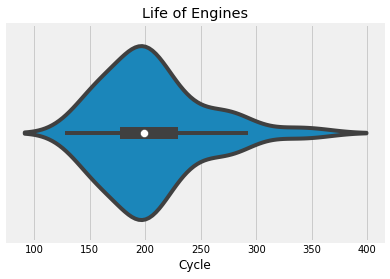

In [132]:
temp_df = df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max()
sns.violinplot(temp_df.Cycle)
plt.title("Life of Engines")

As the plot shows, average life of an Engine is around 200 cycles but some engines lived 360 cycles as well.

##### Engines having maximum life

In [133]:
df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max().sort_values(by = ["Cycle"], ascending= False).head(5)

,Cycle
UnitNumber,
69,362
92,341
96,336
67,313
83,293


##### Engines having minimum life

In [134]:
df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max().sort_values(by = ["Cycle"], ascending= False).tail(5)

,Cycle
UnitNumber,
24,147
57,137
70,137
91,135
39,128


### Operational Setting

In our data set, each engine operates under slightly different conditions, characterized by three dimensions which change over time (e.g. altitude or external air pressure). The figure below shows the values of these operational conditions over time for the same example engine.

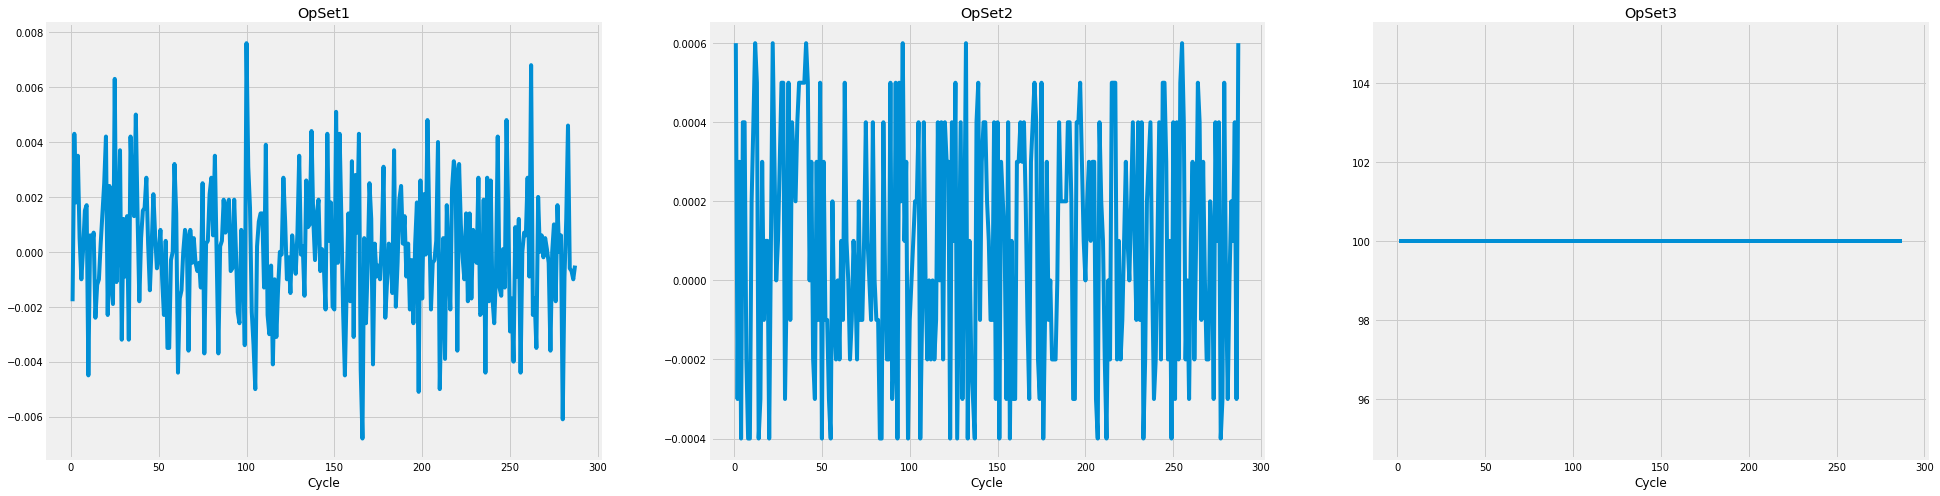

In [135]:
fig,ax=plt.subplots(1,3,figsize=(30,8),sharex='all')
for i in range(0,3):
    df_u1=df_train.query('UnitNumber==2')
    ax[i].plot(df_u1.Cycle.values, df_u1['OpSet'+str(i+1)])
    ax[i].set_title('OpSet'+str(i+1))
    ax[i].set_xlabel("Cycle")

Operational settings do not show any specific characteristics with respect to the time. They do not add value to analysis.

### Sensor Measurements

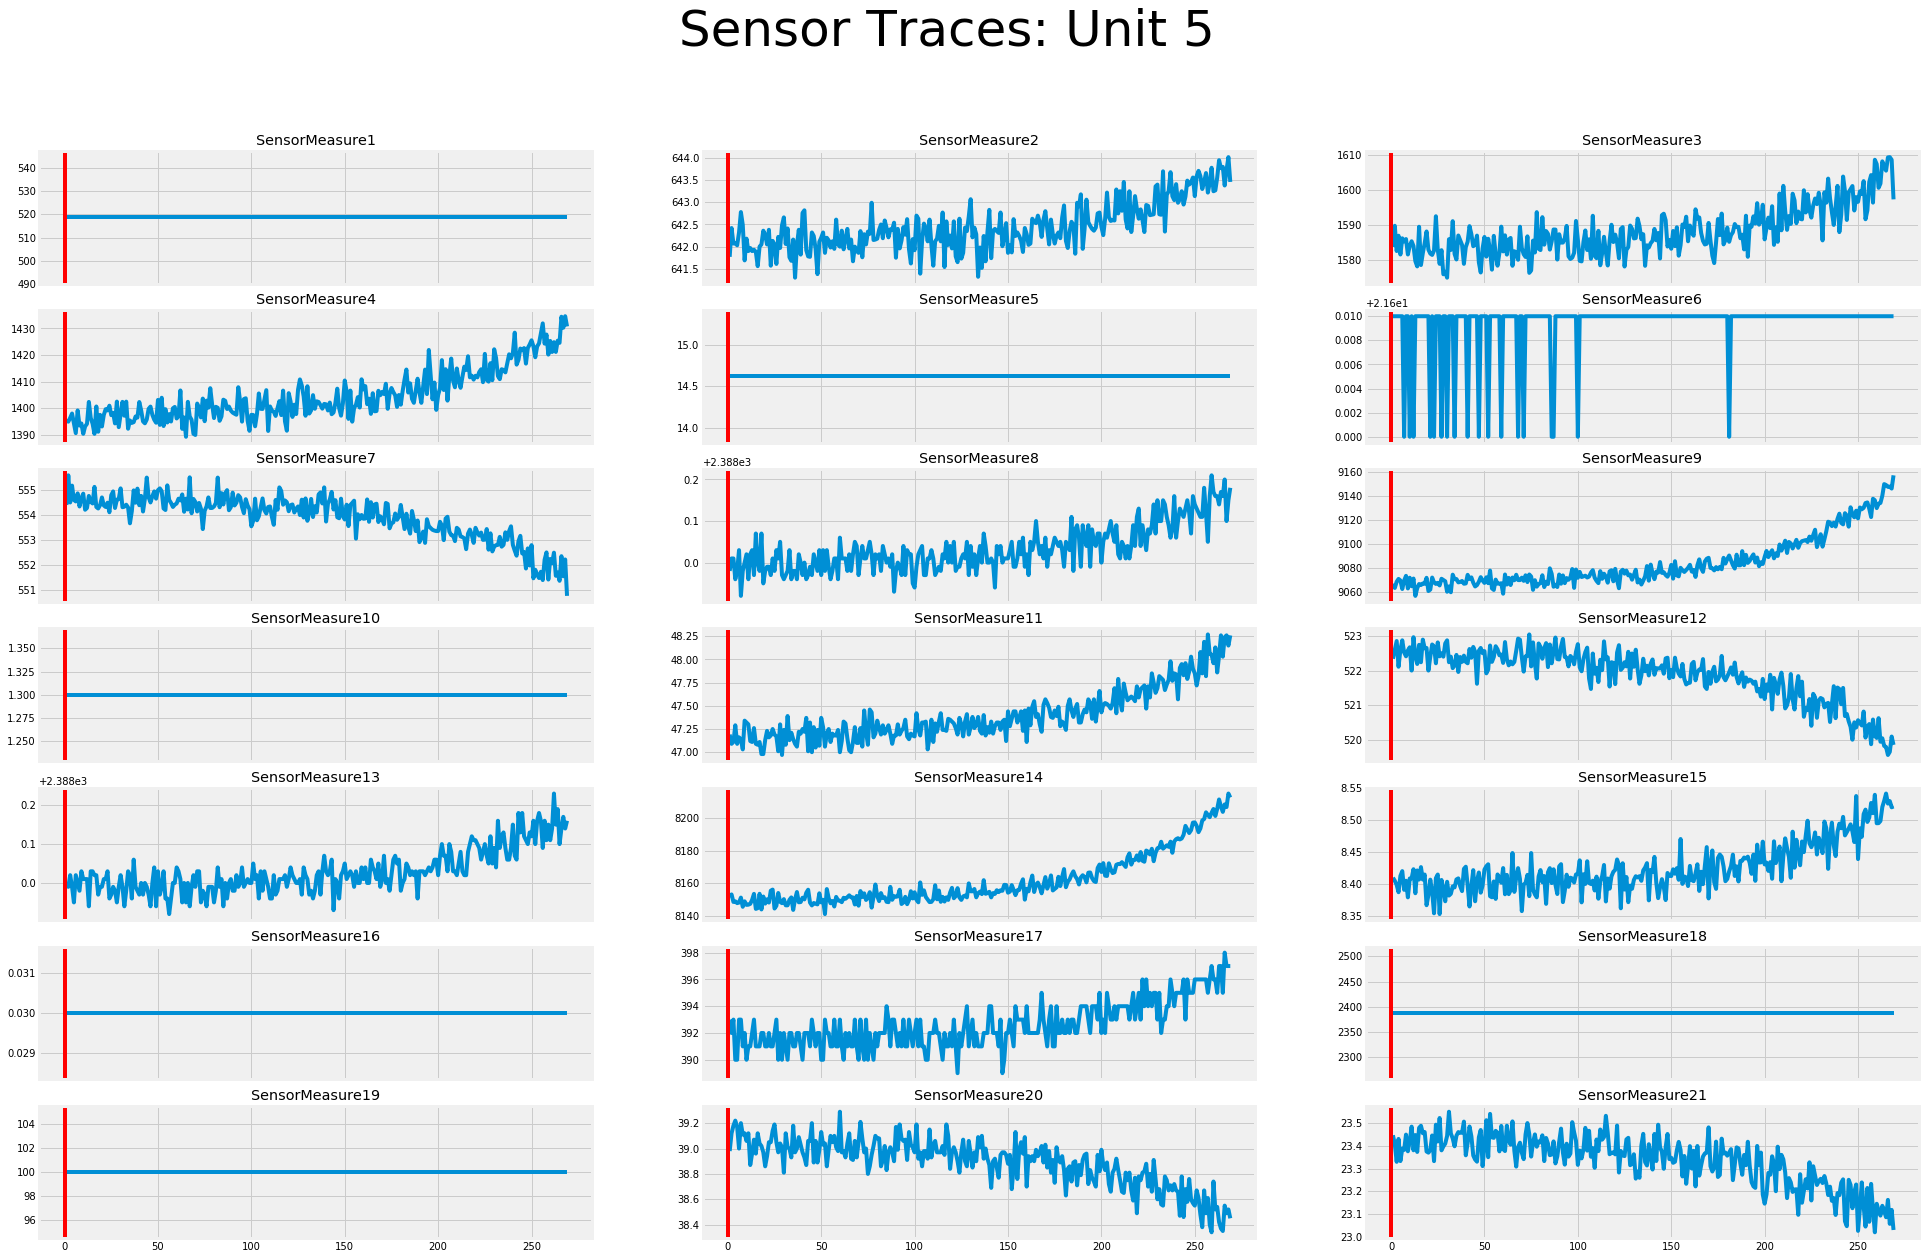

In [136]:
fig,ax=plt.subplots(7,3,figsize=(30,20),sharex=True)
df_u1=df_train.query('UnitNumber==5')
c=0
for i in range(0,7):
    for j in range(0,3):
        ax[i,j].plot(df_u1.Cycle.values, df_u1['SensorMeasure'+str(c+1)])
        ax[i,j].set_title('SensorMeasure'+str(c+1))
        ax[i,j].axvline(0,c='r')
        c+=1
plt.suptitle('Sensor Traces: Unit 5',fontsize=50)
plt.show()

As we can see SensorMeasure1, SensorMeasure5, SensorMeasure6, SensorMeasure10, SensorMeasure16, SensorMeasure18 and SensorMeasure19 do not add value and we can remove them from analysis to reduce the complexity of our model. 

In [137]:
# necessary features for analysis
not_required_feats = ["SensorMeasure1", "SensorMeasure5", "SensorMeasure6", "SensorMeasure10", "SensorMeasure16", "SensorMeasure18", "SensorMeasure19"]
feats = [feat for feat in sensor_measure_columns_names if feat not in not_required_feats]
feats

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

### Correlation Analysis

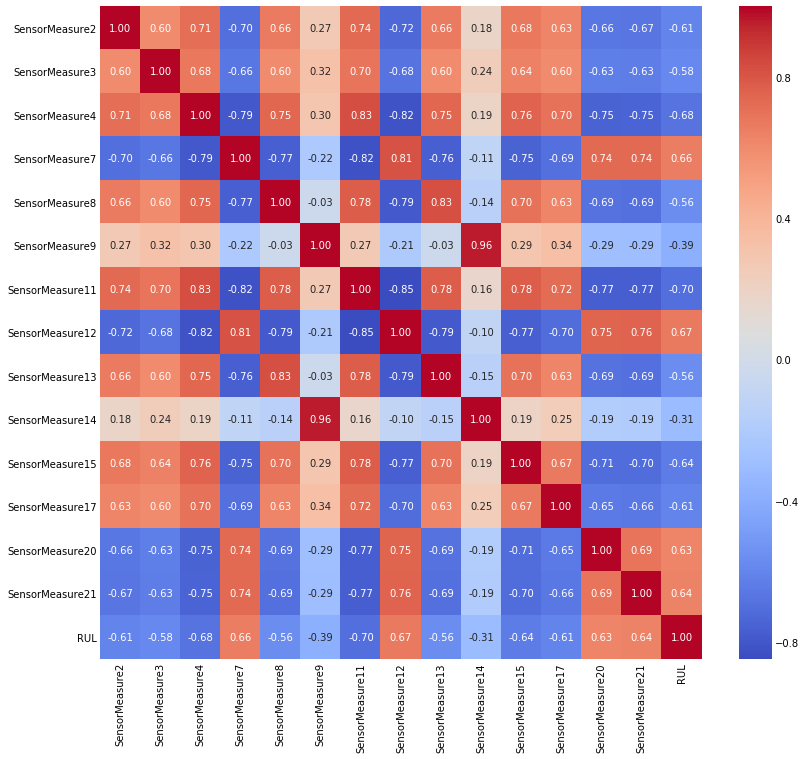

In [138]:
corr = df_train[feats + ["RUL"]].corr()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax = sns.heatmap(corr, annot=True, cmap = "coolwarm", fmt=".2f")

As we can see, Sensor 14 and Sensor 9 are higly correlated.

### Visualizing sensor values before failure

C:\Users\archd\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


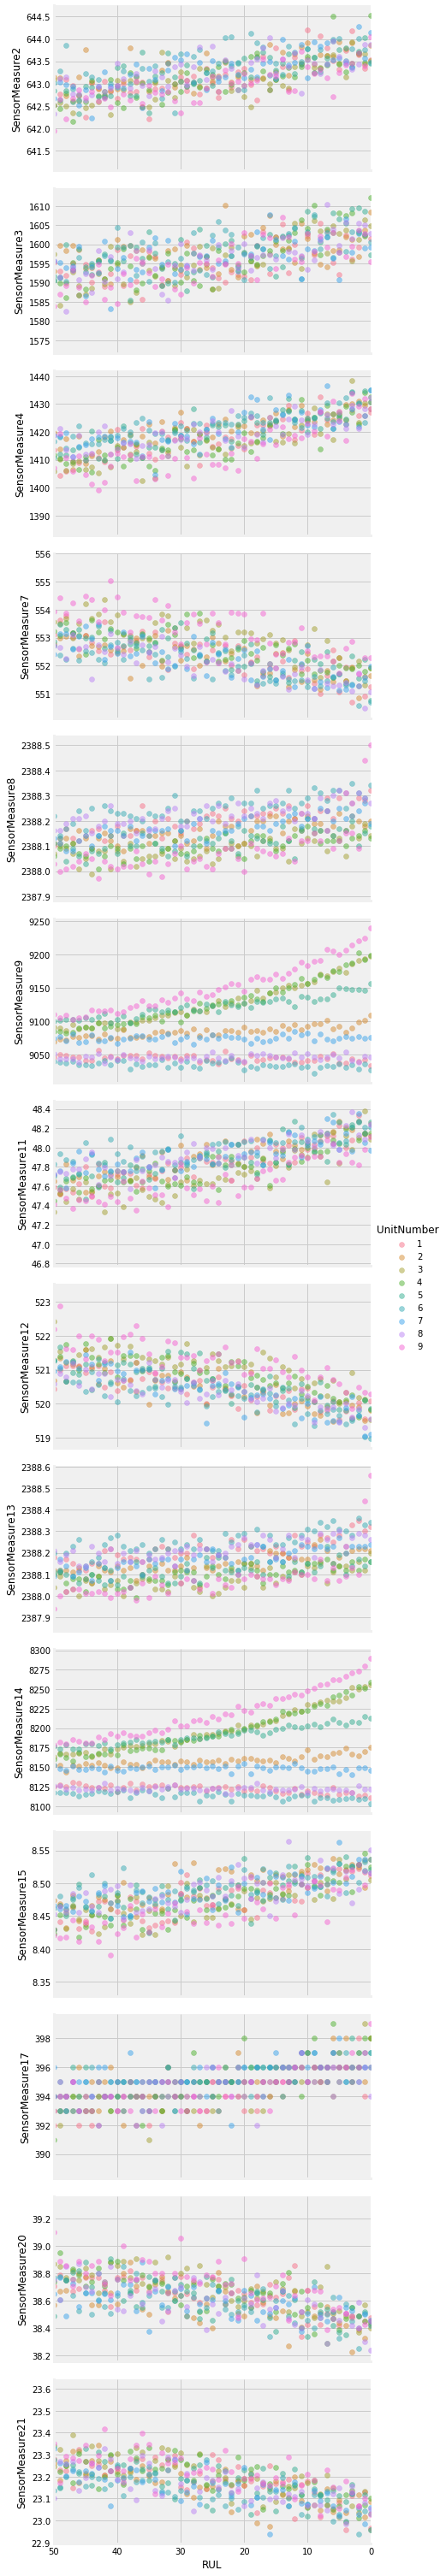

In [139]:
pairPlot = sns.PairGrid(data = df_train[df_train.UnitNumber < 10], x_vars = "RUL", y_vars = feats, hue = "UnitNumber", size = 3, aspect = 2)
pairPlot = pairPlot.map(plt.scatter, alpha = 0.5)
pairPlot = pairPlot.set(xlim = (50, 0))
pairPlot = pairPlot.add_legend()

As we can see sensor9 and sensor14 values diverge and this would not help us building our model. Let's see relationship between these sensor readings.

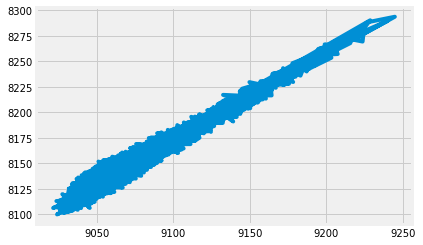

In [140]:
plt.plot(df_train.SensorMeasure9, df_train.SensorMeasure14)

Both of these sensor readings are highly correlated and this increases our model's complexity. I need to drop both of them as they can have any value before failure

In [141]:
feats.remove("SensorMeasure9")
feats.remove("SensorMeasure14")
feats

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

## Model

### Data Preprocessing

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [142]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])

C:\Users\archd\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\archd\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [196]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [197]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [327]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [233]:
sequence_length = 50
mask_value = 0


Let's prepare data using above functions.

In [328]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 12)


In [329]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [330]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 12)


In [332]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

### LSTM Model

In [333]:
nb_features = x_train.shape[2]
nb_out = 1

history = History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 100)           45200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 125,701
Trainable params: 125,701
Non-trainable params: 0
_________________________________________________________________


In [334]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 14944 samples, validate on 787 samples
Epoch 1/100
14944/14944 [==============================] - 42s 3ms/step - loss: 8156.9126 - mean_squared_error: 8156.9126 - val_loss: 7352.1227 - val_mean_squared_error: 7352.1227
Epoch 2/100
14944/14944 [==============================] - 37s 2ms/step - loss: 7059.6051 - mean_squared_error: 7059.6051 - val_loss: 6438.2411 - val_mean_squared_error: 6438.2411
Epoch 3/100
14944/14944 [==============================] - 38s 3ms/step - loss: 6175.3451 - mean_squared_error: 6175.3451 - val_loss: 5609.8855 - val_mean_squared_error: 5609.8855
Epoch 4/100
14944/14944 [==============================] - 38s 3ms/step - loss: 5379.8326 - mean_squared_error: 5379.8326 - val_loss: 4861.4595 - val_mean_squared_error: 4861.4595
Epoch 5/100
14944/14944 [==============================] - 38s 3ms/step - loss: 4673.1289 - mean_squared_error: 4673.1289 - val_loss: 4201.0127 - val_mean_squared_error: 4201.0127
Epoch 6/100
14944/14944 [===========================

Let's plot the loss

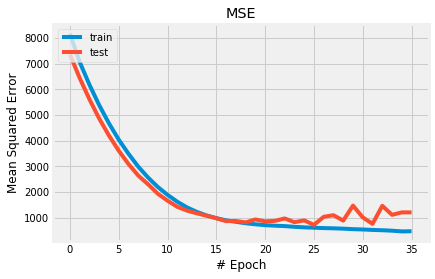

In [335]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results on Train Set

In [336]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

15731/15731 [==============================] - 13s 810us/step
MSE: 552.2123510472145


### Results on Test Set

In [337]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))

MSE: 1061.5288381958007


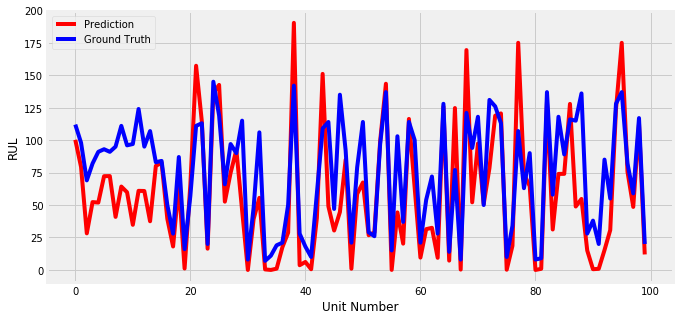

In [338]:
y_pred_test = model.predict(x_test, verbose=0)

plt.figure(figsize=(10,5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()